# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

![GAN Pipeline](assets/gan_pipeline.png)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

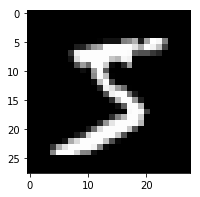

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

In [4]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [5]:
train_on_gpu

True

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

![GAN Network](assets/gan_network.png)

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

![Leaky RELU](assets/leaky_relu.png)

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** and binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        self.fc1_layer = nn.Linear(input_size, hidden_dim * 4)
        self.fc2_layer = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3_layer = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc4_layer = nn.Linear(hidden_dim, output_size)
        self.leaky_relu_activation = nn.LeakyReLU(negative_slope=0.2)
        self.dropout_function = nn.Dropout(0.3)
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28 * 28)
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = self.fc1_layer(x)
        x = self.leaky_relu_activation(x)
        x = self.dropout_function(x)
        
        x = self.fc2_layer(x)
        x = self.leaky_relu_activation(x)
        x = self.dropout_function(x)
        
        x = self.fc3_layer(x)
        x = self.leaky_relu_activation(x)
        x = self.dropout_function(x)
        
        x = self.fc4_layer(x)
        
        return x

## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

![Hyperbolic Tangent](assets/tanh_fn.png)

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

I'll do this in the training loop, later on.

In [7]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        self.fc1_layer = nn.Linear(input_size, hidden_dim)
        self.fc2_layer = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3_layer = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc4_layer = nn.Linear(hidden_dim * 4, output_size)
        self.leaky_relu_activation = nn.LeakyReLU(negative_slope=0.2)
        self.dropout_function = nn.Dropout(0.3)

    def forward(self, x):
        # pass x through all layers
        # final layer should have tanh applied
        x = self.fc1_layer(x)
        x = self.leaky_relu_activation(x)
        x = self.dropout_function(x)
        
        x = self.fc2_layer(x)
        x = self.leaky_relu_activation(x)
        x = self.dropout_function(x)
        
        x = self.fc3_layer(x)
        x = self.leaky_relu_activation(x)
        x = self.dropout_function(x)
        
        x = self.fc4_layer(x)
        x = torch.tanh(x)
        
        return x

## Model hyperparameters

In [8]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 28 * 28
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 28 * 28
# Size of *first* hidden layer in the generator
g_hidden_size = 32

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [9]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1_layer): Linear(in_features=784, out_features=128, bias=True)
  (fc2_layer): Linear(in_features=128, out_features=64, bias=True)
  (fc3_layer): Linear(in_features=64, out_features=32, bias=True)
  (fc4_layer): Linear(in_features=32, out_features=1, bias=True)
  (leaky_relu_activation): LeakyReLU(negative_slope=0.2)
  (dropout_function): Dropout(p=0.3)
)

Generator(
  (fc1_layer): Linear(in_features=100, out_features=32, bias=True)
  (fc2_layer): Linear(in_features=32, out_features=64, bias=True)
  (fc3_layer): Linear(in_features=64, out_features=128, bias=True)
  (fc4_layer): Linear(in_features=128, out_features=784, bias=True)
  (leaky_relu_activation): LeakyReLU(negative_slope=0.2)
  (dropout_function): Dropout(p=0.3)
)


In [10]:
if train_on_gpu:
    D = D.cuda()
    G = G.cuda()

---
## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

![GAN Pipeline](assets/gan_pipeline.png)

The losses will be binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [11]:
# Calculate losses
def real_loss(D_out, smooth=False, train_on_gpu=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out, train_on_gpu=False):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [12]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [13]:
import pickle as pkl

# training hyperparams
num_epochs = 40

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
if train_on_gpu:
    fixed_z = fixed_z.cuda()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        if train_on_gpu:
            real_images = real_images.cuda()
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
                
        # 1. Train with real images

        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_out=D_real, smooth=True, train_on_gpu=train_on_gpu)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images    
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_out=D_fake, train_on_gpu=train_on_gpu)
        
        # add up real and fake losses and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        # use real loss to flip labels
        # NOT RECOMMENDED: use proper flip labels instead
        g_loss = real_loss(D_fake, train_on_gpu=train_on_gpu)
        
        # perform backprop
        g_loss.backward() 
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   40] | d_loss: 1.3933 | g_loss: 0.6633
Epoch [    1/   40] | d_loss: 0.5699 | g_loss: 6.3021
Epoch [    1/   40] | d_loss: 1.0706 | g_loss: 1.6148
Epoch [    2/   40] | d_loss: 0.8709 | g_loss: 1.5270
Epoch [    2/   40] | d_loss: 1.1354 | g_loss: 0.9178
Epoch [    2/   40] | d_loss: 1.2664 | g_loss: 0.9641
Epoch [    3/   40] | d_loss: 0.9324 | g_loss: 1.5222
Epoch [    3/   40] | d_loss: 1.0924 | g_loss: 1.4247
Epoch [    3/   40] | d_loss: 1.1304 | g_loss: 1.4694
Epoch [    4/   40] | d_loss: 1.1282 | g_loss: 1.2518
Epoch [    4/   40] | d_loss: 1.1737 | g_loss: 2.3835
Epoch [    4/   40] | d_loss: 1.1860 | g_loss: 1.8183
Epoch [    5/   40] | d_loss: 1.1673 | g_loss: 1.0870
Epoch [    5/   40] | d_loss: 1.0529 | g_loss: 1.8993
Epoch [    5/   40] | d_loss: 1.3613 | g_loss: 1.1603
Epoch [    6/   40] | d_loss: 0.9780 | g_loss: 1.3475
Epoch [    6/   40] | d_loss: 1.0260 | g_loss: 1.1288
Epoch [    6/   40] | d_loss: 0.9775 | g_loss: 1.9618
Epoch [    7/   40] | d_loss

__GPU Utilization__
```
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 18 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 16 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 18 %, 3 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 16 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 18 %, 3 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 18 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 20 %, 3 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 16 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 18 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 18 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
GeForce GTX 1060, 0, 62, 17 %, 2 %, 6078 MiB, 5156 MiB, 922 MiB
```

```
$ nvidia-smi
Sun Mar 24 17:15:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   63C    P2    33W /  N/A |    916MiB /  6078MiB |     15%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0     10232      C   ...ka/anaconda3/envs/pytorch0.4/bin/python   439MiB |
+-----------------------------------------------------------------------------+
```

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

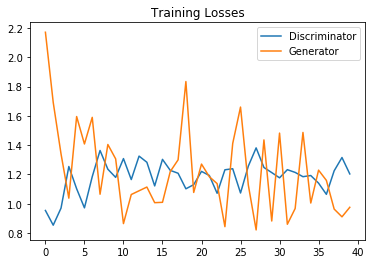

In [14]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [15]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [16]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

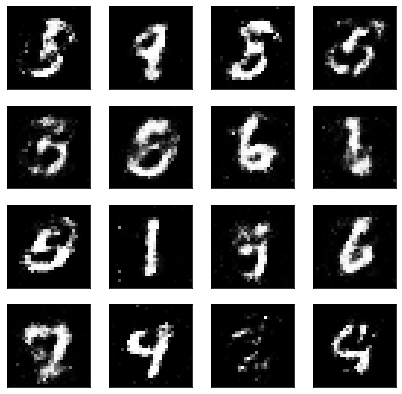

In [17]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

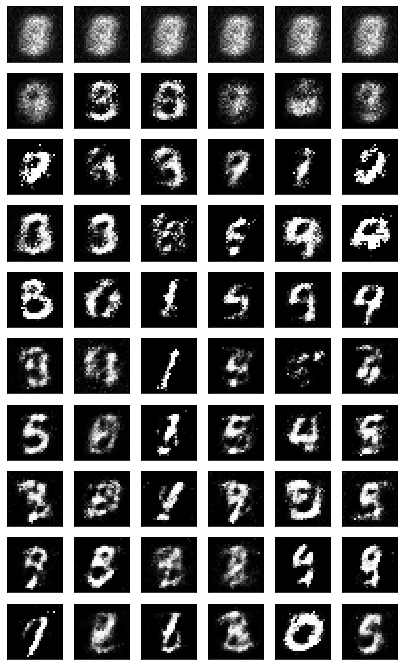

In [18]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

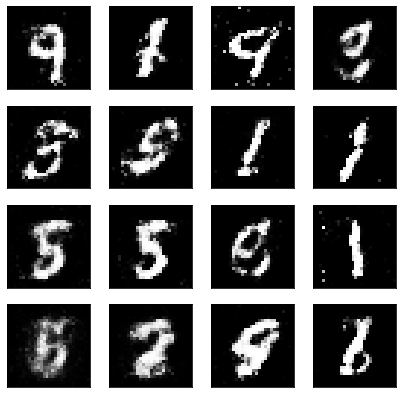

In [20]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
if train_on_gpu:
    rand_z = rand_z.cuda()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])